In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

### Load model

In [3]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
image.permute(1, 2, 0).shape: torch.Size([28, 28, 1])
Label: 5


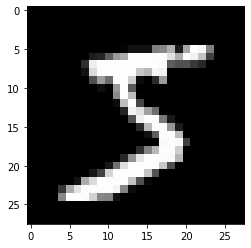

In [7]:
image, label = dataset[0]
print('image.shape:', image.shape)
print('image.permute(1, 2, 0).shape:', image.permute(1, 2, 0).shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [8]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

### Define batch size and data loader

In [9]:
batch_size = 128

train_loader = DataLoader(train_ds, shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=2*batch_size, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


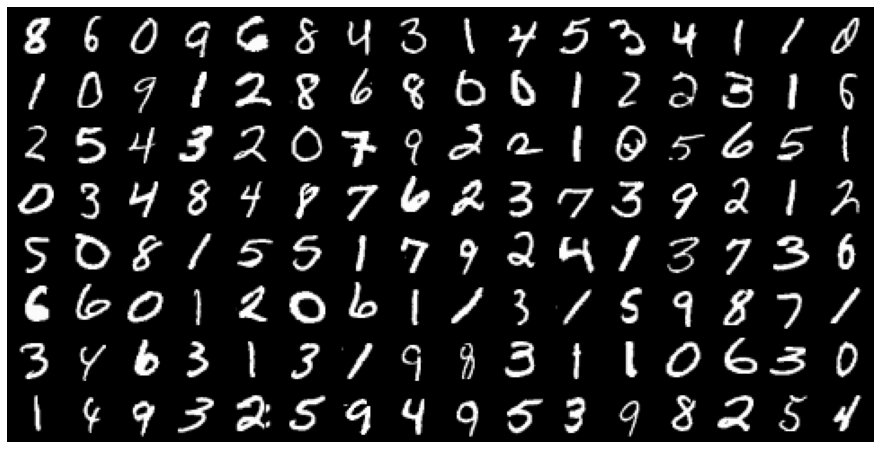

In [10]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

### Define a simple model

In [20]:
layer1 = nn.Linear(784, 32)

In [13]:
layer0 = nn.Flatten()

In [35]:
for images, labels in train_loader:
    inputs = images
    labels = labels
    break

In [17]:
layer0_out = layer0(inputs)
print(layer0_out.shape)

torch.Size([128, 784])


In [21]:
layer1_out = layer1(layer0_out)
print(layer1_out.shape)

torch.Size([128, 32])


In [22]:
layer1_outputs_direct = layer0_out @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [24]:
torch.allclose(layer1_out, layer1_outputs_direct, 1e-3)

True

In [28]:
F.relu(torch.tensor([1, -1, 0, 2]))

tensor([1, 0, 0, 2])

In [31]:
relu_outputs = F.relu(layer1_out)
print(torch.min(layer1_out).item())
print(torch.min(relu_outputs).item())

-0.6607681512832642
0.0


In [32]:
layer2 = nn.Linear(32, 10)

In [33]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [36]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3153, grad_fn=<NllLossBackward>)

In [38]:
labels.shape

torch.Size([128])

In [40]:
outputs_direct = (F.relu(layer0_out @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [42]:
torch.allclose(layer2_outputs, outputs_direct, 1e-3)

True

In [44]:
outputs2 = (layer0_out @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

combined_layer = nn.Linear(784, 10)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

outputs3 = layer0_out @ combined_layer.weight.t() + combined_layer.bias

torch.allclose(outputs2, outputs3, 1e-3)

True

### Define final model

In [55]:
class MnistModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        self.layer0 = nn.Flatten()
        self.layer1 = nn.Linear(in_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, inputs):
        out = self.layer0(inputs)
        out = self.layer1(out)
        out = F.relu(out)
        out = self.layer2(out)
        
        return out

In [47]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [48]:
input_size = 784
hidden_size = 32 
num_classes = 10

In [56]:
model = MnistModel(input_size, hidden_size, num_classes)

In [58]:
for p in model.parameters():
    print(p.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [61]:
torch.cuda.is_available()

True

In [63]:
device = torch.device('cuda')

### Transfer model and data to GPU

In [64]:
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [65]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [66]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [67]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [90]:
def fit(epochs, lr, model, train_loader, val_loader, cost_func=F.cross_entropy, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    
    for epoch in range(epochs):
        
        for images, labels in train_loader:
            predictions = model(images)
            loss = cost_func(predictions, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        history.append(evaluate(model, val_loader, epoch=epoch))
    return history

In [84]:
def evaluate(model, data_loader, epoch=-1, cost_func=F.cross_entropy):
    outputs = []
    for images, labels in val_loader:
        predictions = model(images)
        loss = cost_func(predictions, labels)
        acc = accuracy(predictions, labels)
        outputs.append({'val_loss': loss, 'val_acc': acc})
        
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      
    history = {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    if epoch != -1:
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, epoch_loss.item(), epoch_acc.item()))
    return history

In [74]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (layer0): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=10, bias=True)
)

In [87]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.14475488662719727, 'val_acc': 0.956738293170929}]

### Train model

In [91]:
history += fit(epochs=5, lr=0.5, model=model, train_loader=train_loader, val_loader=val_loader)

Epoch [0], val_loss: 0.1379, val_acc: 0.9598
Epoch [1], val_loss: 0.1246, val_acc: 0.9644
Epoch [2], val_loss: 0.1373, val_acc: 0.9596
Epoch [3], val_loss: 0.1250, val_acc: 0.9633
Epoch [4], val_loss: 0.1391, val_acc: 0.9608


In [92]:
history += fit(epochs=5, lr=0.1, model=model, train_loader=train_loader, val_loader=val_loader)

Epoch [0], val_loss: 0.1160, val_acc: 0.9681
Epoch [1], val_loss: 0.1145, val_acc: 0.9681
Epoch [2], val_loss: 0.1152, val_acc: 0.9667
Epoch [3], val_loss: 0.1144, val_acc: 0.9666
Epoch [4], val_loss: 0.1143, val_acc: 0.9682


### Plot loss and accuracy per epoch

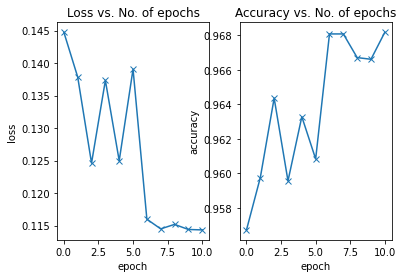

In [95]:
fig, axes = plt.subplots(1, 2)
losses = [x['val_loss'] for x in history]
accuracies = [x['val_acc'] for x in history]

axes[0].plot(losses, '-x')
plt.sca(axs[0])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

axes[1].plot(accuracies, '-x')
plt.sca(axes[1])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

### Test model

In [97]:
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

In [100]:
def predict_image(index, model):
    img, label = test_dataset[index]
    inp = to_device(img.unsqueeze(0), device)
    pred = model(inp)
    _, preds = torch.max(pred, dim=1)
    plt.imshow(img[0], cmap='gray')
    print('Label:', label, ', Predicted:', preds[0].item())

133
Label: 7 , Predicted: 7


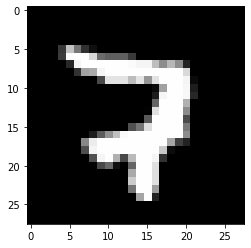

In [104]:
index = int(input())
predict_image(index, model)

In [105]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.11433090269565582, 'val_acc': 0.9681640863418579}

### Save model

In [106]:
torch.save(model, 'mnist-logistic.pth')

In [107]:
model2 = torch.load('mnist-logistic.pth')

In [108]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.11433090269565582, 'val_acc': 0.9681640863418579}